# ML Summer School - Assignment 2

Welcome to Machine Learning Summer School (2018) - Assignment 2. In this, assignment you will be making a spam classifer. That is given a SMS, you have to build a model that classifies whether the message is a spam or ham (not spam). 

Go through this Notebook very carefully. There are links to resources given in between, it is expected you go through them.

The first step we will do is to import the machine learning libraries. We will be using NumPy, Matplotlib, Pandas, and scikit-learn in this assignment. We will also be using NLTK (a library widely used for text processing).

# Importing libraries

In [176]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Loading data

### TASK 1

The first task you need to do is load the csv file as a Pandas DataFrame. First go ahead and open `sms-spam.csv` file in a text editor. Analyse the data - how many columns are there, how big the data is. Identify some patterns which may help the algorithm in classififcation.   

Load the csv as a Pandas DataFrame. The Pandas DataFrame should be named `df` and must contain only two columns named `text` and `is spam`. The `text` column should contain the SMS and `is spam` column should contain `1` if the SMS is spam and `0` if the SMS is a ham.


You will need to use Pandas' `read_csv` function. The csv file is in `latin1` encoding. You will need to care take of that. You may find `encoding`, `usecols` and `names` arguments of `read_csv` helpful.  
To convert 'spam' and 'ham' to 1 and 0 respectively, you may find `DataFrame.apply` useful.

In [118]:
# YOUR CODE STARTS HERE
SPAM_VALUE = 1
HAM_VALUE = 0

def fun(series):
    series[0] = SPAM_VALUE if series[0] == 'spam' else HAM_VALUE
    return series

df = pd.read_csv('sms-spam.csv', header=0, usecols=(0, 1), names=('is spam', 'text'), encoding='latin_1')
df.apply(fun, axis=1)
# YOUR CODE ENDS HERE

df.head()

,is spam,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# Analysing data

The second step in Machine Learning Pipeline is to analyse the data. Analysing the data helps in [Feature Engineering](https://medium.com/mindorks/what-is-feature-engineering-for-machine-learning-d8ba3158d97a).  

The most important part of traditional Machine Learning is how well you represent the data. Tradional Machine Learning approaches can't work directly on raw data. You need to represent the data in a way that is easy for machines to work with.

In this section, we will analyse the data and side by side engineer new features.

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
is spam    5572 non-null object
text       5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


We see that we don't have any data misising. So, we don't need to [handle missing data](https://machinelearningmastery.com/handle-missing-data-python/).

In [120]:
df.groupby('is spam').describe()

text                                                               
        count unique                                                top freq
is spam                                                                     
0        4825   4516                             Sorry, I'll call later   30
1         747    653  Please call our customer service representativ...    4

[`groupby`](https://www.datacamp.com/community/tutorials/pandas-split-apply-combine-groupby) is a powerful way to analyse (and manipulate the data).  
Using the above command, we can see that 747 messages are spam, while 4825 messages are ham. We also observe that most of the message are unique.

### TASK 2

Plot a pie chart showing the number of spam and ham messages in the dataset. Make sure you use you give it a title and use change the default colors (green or red maybe?).

([<matplotlib.patches.Wedge at 0x7fcc7ae16588>,
 [Text(-1.00387,0.449713,'ham'), Text(1.09513,-0.490596,'spam')],
 [Text(-0.547566,0.245298,'86%'), Text(0.638827,-0.286181,'13%')])

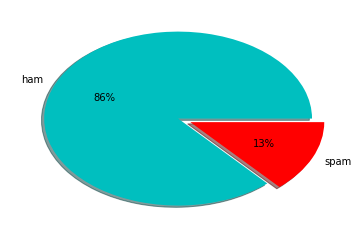

In [121]:
# YOUR CODE STARTS HERE
count_sms_type = df.groupby('is spam').count()
plt.pie(
    x=(count_sms_type.iloc[0][0], count_sms_type.iloc[1][0]), 
    labels=('ham', 'spam'),
    shadow=True,
    autopct='%d%%',
    explode=(0, 0.1),
    colors=('c', 'r')
)
# YOUR CODE ENDS HERE

# Adding features

## Percentage digits

If you have gone through the dataset, you would have observed that spam messages have a lot more digits in them as compared to ham messages. So, lets create a feature based on that.

In [122]:
def percentage_digits(text):
    counter = 0
    for i in text:
        if i.isdigit():
            counter += 1
    return (counter / len(text)) * 100

df['percentage digits'] = df['text'].apply(percentage_digits)
df.head()

,is spam,text,percentage digits
0,0,"Go until jurong point, crazy.. Available only ...",0.000000
1,0,Ok lar... Joking wif u oni...,0.000000
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,16.129032
3,0,U dun say so early hor... U c already then say...,0.000000
4,0,"Nah I don't think he goes to usf, he lives aro...",0.000000


Let's plot to check if our observation was correct.

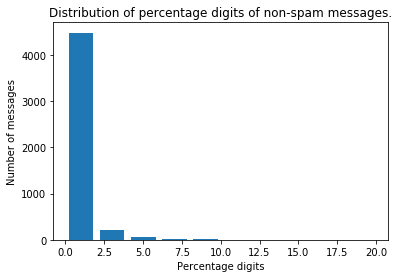

In [123]:
plt.hist(df[df['is spam'] == HAM_VALUE]['percentage digits'], bins=10, range=(0, 20), rwidth=0.8)
plt.xlabel('Percentage digits')
plt.ylabel('Number of messages')
plt.title('Distribution of percentage digits of non-spam messages.')
plt.show()

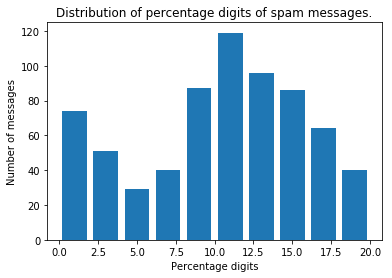

In [124]:
plt.hist(df[df['is spam'] == SPAM_VALUE]['percentage digits'], bins=10, range=(0, 20), rwidth=0.8)
plt.xlabel('Percentage digits')
plt.ylabel('Number of messages')
plt.title('Distribution of percentage digits of spam messages.')
plt.show()

Indeed it was correct. Therefore, we can use this feature for our machine learning model. Let us create a bunch of more features like this.

## Percentage question mark

In [125]:
def percentage_question_mark(text):
    counter = 0
    for i in text:
        if i == '?':
            counter += 1
    return (counter / len(text)) * 100

df['percentage question mark'] = df['text'].apply(percentage_question_mark)
df.head()

,is spam,text,percentage digits,percentage question mark
0,0,"Go until jurong point, crazy.. Available only ...",0.000000,0.0
1,0,Ok lar... Joking wif u oni...,0.000000,0.0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,16.129032,0.0
3,0,U dun say so early hor... U c already then say...,0.000000,0.0
4,0,"Nah I don't think he goes to usf, he lives aro...",0.000000,0.0


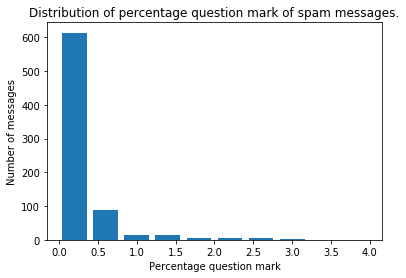

In [126]:
plt.hist(df[df['is spam'] == SPAM_VALUE]['percentage question mark'], bins=10, range=(0, 4), rwidth=0.8)
plt.xlabel('Percentage question mark')
plt.ylabel('Number of messages')
plt.title('Distribution of percentage question mark of spam messages.')
plt.show()

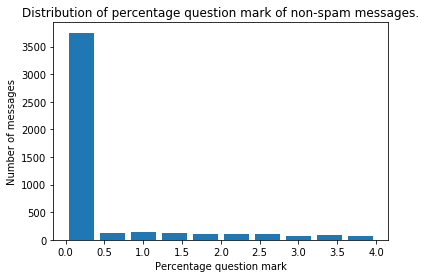

In [127]:
plt.hist(df[df['is spam'] == HAM_VALUE]['percentage question mark'], bins=10, range=(0, 4), rwidth=0.8)
plt.xlabel('Percentage question mark')
plt.ylabel('Number of messages')
plt.title('Distribution of percentage question mark of non-spam messages.')
plt.show()

## Percentage exclamation mark

In [128]:
def percentage_exclamation_mark(text):
    counter = 0
    for i in text:
        if i == '!':
            counter += 1
    return (counter / len(text)) * 100

df['percentage exclamation mark'] = df['text'].apply(percentage_exclamation_mark)
df.head()

,is spam,text,percentage digits,percentage question mark,percentage exclamation mark
0,0,"Go until jurong point, crazy.. Available only ...",0.000000,0.0,0.0
1,0,Ok lar... Joking wif u oni...,0.000000,0.0,0.0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,16.129032,0.0,0.0
3,0,U dun say so early hor... U c already then say...,0.000000,0.0,0.0
4,0,"Nah I don't think he goes to usf, he lives aro...",0.000000,0.0,0.0


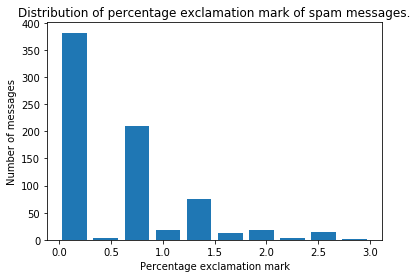

In [129]:
plt.hist(df[df['is spam'] == SPAM_VALUE]['percentage exclamation mark'], bins=10, range=(0, 3), rwidth=0.8)
plt.xlabel('Percentage exclamation mark')
plt.ylabel('Number of messages')
plt.title('Distribution of percentage exclamation mark of spam messages.')
plt.show()

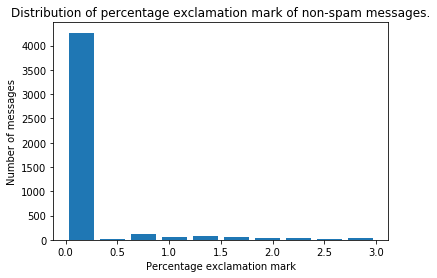

In [130]:
plt.hist(df[df['is spam'] == HAM_VALUE]['percentage exclamation mark'], bins=10, range=(0, 3), rwidth=0.8)
plt.xlabel('Percentage exclamation mark')
plt.ylabel('Number of messages')
plt.title('Distribution of percentage exclamation mark of non-spam messages.')
plt.show()

## Percentage caps

In [131]:
def percentage_caps(text):
    counter = 0
    for i in text:
        if i.isupper():
            counter += 1
    return (counter / len(text)) * 100

df['percentage caps'] = df['text'].apply(percentage_caps)
df.head()

,is spam,text,percentage digits,percentage question mark,percentage exclamation mark,percentage caps
0,0,"Go until jurong point, crazy.. Available only ...",0.000000,0.0,0.0,2.702703
1,0,Ok lar... Joking wif u oni...,0.000000,0.0,0.0,6.896552
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,16.129032,0.0,0.0,6.451613
3,0,U dun say so early hor... U c already then say...,0.000000,0.0,0.0,4.081633
4,0,"Nah I don't think he goes to usf, he lives aro...",0.000000,0.0,0.0,3.278689


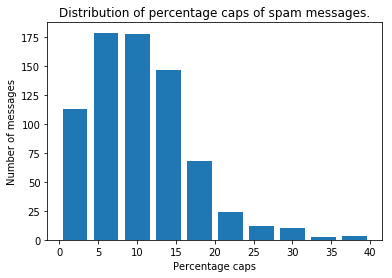

In [132]:
plt.hist(df[df['is spam'] == SPAM_VALUE]['percentage caps'], bins=10, range=(0, 40), rwidth=0.8)
plt.xlabel('Percentage caps')
plt.ylabel('Number of messages')
plt.title('Distribution of percentage caps of spam messages.')
plt.show()

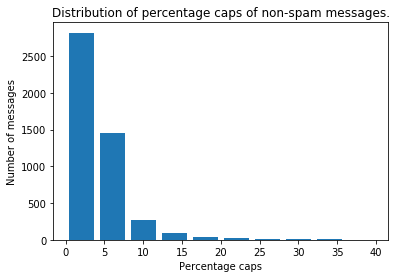

In [133]:
plt.hist(df[df['is spam'] == HAM_VALUE]['percentage caps'], bins=10, range=(0, 40), rwidth=0.8)
plt.xlabel('Percentage caps')
plt.ylabel('Number of messages')
plt.title('Distribution of percentage caps of non-spam messages.')
plt.show()

## Length

In [134]:
df['length'] = df['text'].apply(len)
df.head()

,is spam,text,percentage digits,percentage question mark,percentage exclamation mark,percentage caps,length
0,0,"Go until jurong point, crazy.. Available only ...",0.000000,0.0,0.0,2.702703,111
1,0,Ok lar... Joking wif u oni...,0.000000,0.0,0.0,6.896552,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,16.129032,0.0,0.0,6.451613,155
3,0,U dun say so early hor... U c already then say...,0.000000,0.0,0.0,4.081633,49
4,0,"Nah I don't think he goes to usf, he lives aro...",0.000000,0.0,0.0,3.278689,61


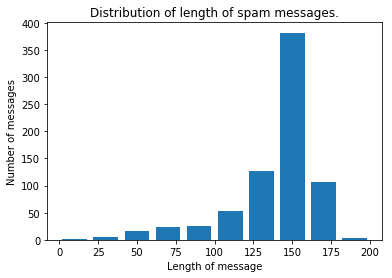

In [135]:
plt.hist(df[df['is spam'] == SPAM_VALUE]['length'], bins=10, range=(0, 200), rwidth=0.8)
plt.xlabel('Length of message')
plt.ylabel('Number of messages')
plt.title('Distribution of length of spam messages.')
plt.show()

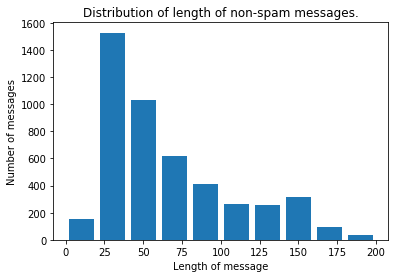

In [136]:
plt.hist(df[df['is spam'] == HAM_VALUE]['length'], bins=10, range=(0, 200), rwidth=0.8)
plt.xlabel('Length of message')
plt.ylabel('Number of messages')
plt.title('Distribution of length of non-spam messages.')
plt.show()

### TASK 3

Your task is to analyse the data, either manually or by Pandas' functions such as `groupby` and `describe` and add atleast one feature. The features created should be supported by some statistic, or some plot. 

Treat this task very seriously. Students whose features are most creative (and effective) will be given a special mention.

## Percentage Periods

In [137]:
# YOUR CODE STARTS HERE
def percentage_periods(text):
    counter = 0
    for c in text:
        if c == '.':
            counter += 1
    return (counter / len(text)) * 100
df['percentage periods'] = df['text'].apply(percentage_periods)
df.head()
# YOUR CODE ENDS HERE

,is spam,text,percentage digits,percentage question mark,percentage exclamation mark,percentage caps,length,percentage periods
0,0,"Go until jurong point, crazy.. Available only ...",0.000000,0.0,0.0,2.702703,111,7.207207
1,0,Ok lar... Joking wif u oni...,0.000000,0.0,0.0,6.896552,29,20.689655
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,16.129032,0.0,0.0,6.451613,155,0.645161
3,0,U dun say so early hor... U c already then say...,0.000000,0.0,0.0,4.081633,49,12.244898
4,0,"Nah I don't think he goes to usf, he lives aro...",0.000000,0.0,0.0,3.278689,61,0.000000


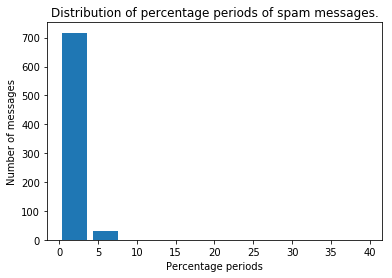

In [138]:
plt.hist(df[df['is spam'] == SPAM_VALUE]['percentage periods'], bins=10, range=(0, 40), rwidth=0.8)
plt.xlabel('Percentage periods')
plt.ylabel('Number of messages')
plt.title('Distribution of percentage periods of spam messages.')
plt.show()

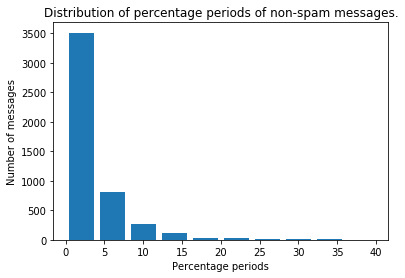

In [139]:
plt.hist(df[df['is spam'] == HAM_VALUE]['percentage periods'], bins=10, range=(0, 40), rwidth=0.8)
plt.xlabel('Percentage periods')
plt.ylabel('Number of messages')
plt.title('Distribution of percentage periods of non-spam messages.')
plt.show()

## Percentage Long words

In [140]:
length = 9
def percentage_long_words(text):
    ar = text.split()
    count = len(list(filter(lambda x: len(x) >= length, ar)))
    return (count / len(ar)) * 100
df['percentage long words'] = df['text'].apply(percentage_long_words)
df.head()

,is spam,text,percentage digits,percentage question mark,percentage exclamation mark,percentage caps,length,percentage periods,percentage long words
0,0,"Go until jurong point, crazy.. Available only ...",0.000000,0.0,0.0,2.702703,111,7.207207,10.000000
1,0,Ok lar... Joking wif u oni...,0.000000,0.0,0.0,6.896552,29,20.689655,0.000000
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,16.129032,0.0,0.0,6.451613,155,0.645161,10.714286
3,0,U dun say so early hor... U c already then say...,0.000000,0.0,0.0,4.081633,49,12.244898,0.000000
4,0,"Nah I don't think he goes to usf, he lives aro...",0.000000,0.0,0.0,3.278689,61,0.000000,0.000000


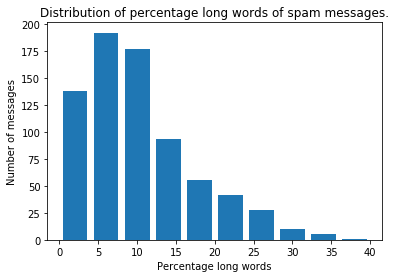

In [141]:
plt.hist(df[df['is spam'] == SPAM_VALUE]['percentage long words'], bins=10, range=(0, 40), rwidth=0.8)
plt.xlabel('Percentage long words')
plt.ylabel('Number of messages')
plt.title('Distribution of percentage long words of spam messages.')
plt.show()

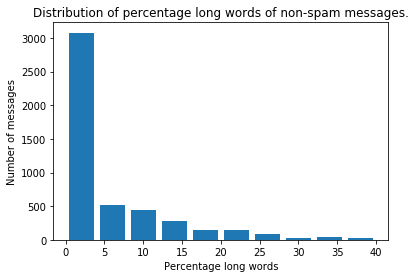

In [142]:
plt.hist(df[df['is spam'] == HAM_VALUE]['percentage long words'], bins=10, range=(0, 40), rwidth=0.8)
plt.xlabel('Percentage long words')
plt.ylabel('Number of messages')
plt.title('Distribution of percentage long words of non-spam messages.')
plt.show()

## Creating Features from the text

Uptil now, we have created additional features from the text. But we have not represented the text itself.   

Remember that machine learning algorithms such as Logistic Regression work by multiplying the feature values by some (learnable) weights. Clealy, we can't use text as it as feature. We need to convert into numbers, a form machine learning algorithm can deal with.     

### Bag of Words

    How do we convert them to some kind of numeric representation for machine learning? One common approach is called a Bag of Words. The Bag of Words model learns a vocabulary from all of the documents, then models each document by counting the number of times each word appears. For example, consider the following two sentences:

    Sentence 1: "The cat sat on the hat"

    Sentence 2: "The dog ate the cat and the hat"

    From these two sentences, our vocabulary is as follows:

    { the, cat, sat, on, hat, dog, ate, and }

    To get our bags of words, we count the number of times each word occurs in each sentence. In Sentence 1, "the" appears twice, and "cat", "sat", "on", and "hat" each appear once, so the feature vector for Sentence 1 is:

    { the, cat, sat, on, hat, dog, ate, and }

    Sentence 1: { 2, 1, 1, 1, 1, 0, 0, 0 }

    Similarly, the features for Sentence 2 are: { 3, 1, 0, 0, 1, 1, 1, 1}
    
More on Bag of Words, [here](https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words), [here](https://machinelearningmastery.com/gentle-introduction-bag-words-model/) and [here](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction).

It is imperative that you understand Bag of Words before moving on.

Bag of Words is not fact the only (and the best) way to represent text. It suffers from problems such as creating too many features, not being able to represent similarities between similar words, and not being able to take into account the sequence in which words appear.  
After learning Deep Learning, you will come to know of other methods to represent text such as using Word vectors and LSTMs.

### Cleaning the text

Now we clean the text by removing non-alphabetic words and [stopwords](http://text-analytics101.rxnlp.com/2014/10/all-about-stop-words-for-text-mining.html) from the text. Stop Words are words that most commonly appear in the language, for example, 'the', 'and', etc. They don't add useful information to the text so they can be removed.

In [65]:
# import string
# translation_map = str.maketrans('', '', string.punctuation)

# def clean_sms(text):
#     text = text.lower()
#     return list(filter(lambda word: word.isalpha() and word not in stopwords.words('english'),
#                   map(lambda word: word.translate(translation_map), text.split())))

We will be using `CountVectorizer` to convert the SMSes to a matrix of token counts. You should try and fiddle with the arguments to `CountVectorizer`

In [143]:
cv = CountVectorizer(
    strip_accents='ascii',
    min_df=5,
    analyzer='word',
    stop_words=stopwords.words('english'),
    lowercase=True
)
matrix = cv.fit_transform(df['text']).todense()
df = pd.concat([df, pd.DataFrame(matrix, columns=cv.get_feature_names())], axis=1)
df.head(2)

,is spam,text,percentage digits,percentage question mark,percentage exclamation mark,percentage caps,length,percentage periods,percentage long words,00,...,yijue,ym,yo,yoga,yogasana,yr,yrs,yun,yup,zed
0,0,"Go until jurong point, crazy.. Available only ...",0.0,0.0,0.0,2.702703,111,7.207207,10.0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,Ok lar... Joking wif u oni...,0.0,0.0,0.0,6.896552,29,20.689655,0.0,0,...,0,0,0,0,0,0,0,0,0,0


This is how our final feature vector (plus the target vector) looks like.

In [144]:
df.groupby('is spam').mean()

,percentage digits,percentage question mark,percentage exclamation mark,percentage caps,length,percentage periods,percentage long words,00,000,02,...,yijue,ym,yo,yoga,yogasana,yr,yrs,yun,yup,zed
is spam,,,,,,,,,,,,,,,,,,,,,
0,0.420082,0.544954,0.233188,5.952566,71.023627,3.302500,5.134118,0.000000,0.000000,0.00000,...,0.001451,0.001036,0.007461,0.001451,0.001036,0.000622,0.001036,0.001036,0.008912,0.000000
1,11.579405,0.169521,0.524716,11.061228,138.866131,1.503612,10.639467,0.013387,0.038822,0.01071,...,0.000000,0.000000,0.004016,0.000000,0.000000,0.014726,0.004016,0.000000,0.000000,0.008032


The table above shows mean values for all the features grouped by whether the text is spam or ham.  
Clearly, the values are very different for the features we manually created. That means we have created good features.

# Training model and calculating accuracy

### TASK 4

Extract `X`, the feature vectors by removing the label (`is spam` column) and the text (`text` column) from the `df` DataFrame.  
Similarly extract the target vectors, by assigning `Y` to the `is spam` column.

In [145]:
# YOUR CODE STARTS HERE
y = df['is spam'].as_matrix()
X = df.drop(columns=['is spam', 'text'])
y = y.astype('int')
print(X.info())
# YOUR CODE ENDS HERE

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Columns: 1705 entries, percentage digits to zed
dtypes: float64(6), int64(1699)
memory usage: 72.5 MB
None


In [146]:
print("X.shape:", X.shape)
print("y.shape:", y.shape)

X.shape: (5572, 1705)
y.shape: (5572,)


Now we divide the dataset into 3 parts, `train`, `cv` and `test`. We train our model on the training set, tune the hyperparameters (regularisation factor, which algorithm to use) on the validation set and finally report the our results on the test set.

In this case we keep 60% of the data in training set, 20% of the data in validation set, and 20% of the data in test set. 

### Splitting the dataset

In [147]:
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.4, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_other, y_other, test_size=0.5, random_state=42)

print("Train dataset size: ", X_train.shape[0])
print("CV size: ", X_cv.shape[0])
print("Test size: ", X_test.shape[0])

Train dataset size:  3343
CV size:  1114
Test size:  1115


Now we try out different models and fiddle around with the hyperparameters, seeing their accuracy on the validation set.

#### Logistic Regression

Now will use the Logistic Regression class from the scikit-learn library to create a classifier object and train it on our data.

In [180]:
clf1 = LogisticRegression()
clf1 = clf1.fit(X_train, y_train)

Fiddle around the paramaters while creating the classifier object, particularly with `C` - the regularisation strength, `class_weight` - a useful paramter when dealing with skewed class distribution like this. You can change the regularisation strength by observing how it is performing on the training set and the validation set.

We will be using f1-score to evaluate the model. F1-score is used when the class distribution is skewed (like in this example).   
More about F1-Score [here](https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/). Do read this before moving on.

In [181]:
print(classification_report(y_cv, clf1.predict(X_cv), target_names=['ham', 'spam']))
print('F1 score:', f1_score(y_cv, clf1.predict(X_cv)))

             precision    recall  f1-score   support

        ham       0.99      0.99      0.99       955
       spam       0.97      0.94      0.95       159

avg / total       0.99      0.99      0.99      1114

F1 score: 0.952076677316294


#### Naive Bayes

Similarly fiddle around with the hyper parameters of this model. You can find the documentation on the scikit-learn website.

In [182]:
clf2 = MultinomialNB()
clf2 = clf2.fit(X_train, y_train)

In [183]:
print(classification_report(y_cv, clf2.predict(X_cv), target_names=['ham', 'spam']))
print('F1 score:', f1_score(y_cv, clf2.predict(X_cv)))

             precision    recall  f1-score   support

        ham       0.99      0.98      0.99       955
       spam       0.91      0.97      0.94       159

avg / total       0.98      0.98      0.98      1114

F1 score: 0.9361702127659574


### TASK 5

Use [SVM Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) instead of Logistic Regression and Naive Bayes. 
Print out the classification report and F1 Score as done above.

In [184]:
# YOUR CODE STARTS HERE
clf3 = SVC(kernel='poly')
clf3 = clf3.fit(X_train, y_train)
# YOUR CODE ENDS HERE

In [185]:
print(classification_report(y_cv, clf3.predict(X_cv), target_names=['ham', 'spam']))
print('F1 score:', f1_score(y_cv, clf3.predict(X_cv)))

             precision    recall  f1-score   support

        ham       0.99      0.99      0.99       955
       spam       0.96      0.96      0.96       159

avg / total       0.99      0.99      0.99      1114

F1 score: 0.9622641509433962


### Bonus Task

Try using one of the most basic ensembling method the [VotingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html).
You can read more about ensembing [here](http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/), and [here](https://mlwave.com/kaggle-ensembling-guide/).

In [186]:
# YOUR CODE STARTS HERE
clf = VotingClassifier(estimators=(('svm', clf3), ('nb', clf2), ('lr', clf1)), n_jobs=2)
clf = clf.fit(X_train, y_train)
# YOUR CODE ENDS HERE

### Training the final model

In [187]:
y_actual = y_test
y_predicted = clf.predict(X_test)

In [188]:
true_positives = X_test[(y_actual == 1) & (y_predicted == 1)]
true_negatives = X_test[(y_actual == 0) & (y_predicted == 0)]
false_positives = X_test[(y_actual == 0) & (y_predicted == 1)]
false_negatives = X_test[(y_actual == 1) & (y_predicted == 0)]

In [189]:
precision = true_positives.shape[0] / (true_positives.shape[0] + false_positives.shape[0])
print("Precision:", precision)
recall = true_positives.shape[0] / (true_positives.shape[0] + false_negatives.shape[0])
print("Recall:", recall)
f1_score = 2 * precision * recall / (precision + recall)
print("F1 score:", f1_score)

Precision: 0.9710144927536232
Recall: 0.9571428571428572
F1 score: 0.9640287769784173


The one with the highest F1 Score will get a special mention. To improve on the F1 Score, you can engineer new features, try out more algorithms and loggically fiddle with their parameters.

Congratulations! You have successfully made a spam classifier which is correct most of the time. Isn't it amazing how your computer has learnt to distinguish between spam and non-spam messages? 

#### Observing examples where the algorithm failed, or was successful.

In [190]:
df.loc[list(false_positives.index)]['text']

,text,text
333,Any chance you might have had with me evaporat...,0
990,26th OF JULY,0
4397,Can you tell Shola to please go to college of ...,0
4727,I (Career Tel) have added u as a contact on IN...,0
